# Data exploration

This notebook will explore the images we have and extract data from them. The images have 4 channels (DAPI, EdU, and two Alexa's, one being PCNA). The data we extract from the channels are the pixel intensities.

Pipeline (Pseudo-code) to gather training data:

Upload from Omero all images from a well
For each image
- make a prediction for the cells
- make the crops around the cells in each channel
- make a dataframe with the first row being the one for the Alexa555 (PCNA) image crops
- get the pixel intensity of the crops in each channel and add it to the dataframe where each column corresponds to a channel's intentisity for that crop
- normalise that pixel intensity data per channel

Stack all the dataframes together
Get the DNA value data from the DAPI channel (Helfrid's function) and add it to the dataframe
Get the background value of the Cyclin A2 and EdU channels
Apply the G1, S and G2/M rules where they are each a column in the dataframe with True if the cell's data follows the rule to be in that phase and False if not
Plot that cell cycle phase channel data in a 4D graph where each axis is data from a channel
Plot some cells from each classification cropped in the Alexa555 channel

## Importing data

Note: since I'm working from home right now, I'm struggling with my connection to Omero so I'm importing data I saved from earlier. When I'm back in the lab I will change this part to be importing data from Omero with the plate number.

In [23]:
#Get all images from Omero
import ezomero
import numpy as np

#Step 1: Connect to Omero

HOST = 'ome2.hpc.sussex.ac.uk' #change if different
port=4064
conn = ezomero.connect(user='rz200',password='omeroreset',group='',host=HOST,port=4064,secure=True)
if conn: print('Connection successful')
else: print('Unsuccessful')

#Step 2: Load the images
plate = 822
image_ids = ezomero.get_image_ids(conn,plate=plate)
print('In plate',plate,'we have',len(image_ids),'images')

#Make a loop that goes through each image and store them in a numpy array or even in the dataframe
image = ezomero.get_image(conn,image_id=image_ids[0]) #this gets the first image, it has 4 channels
#ori_img = np.reshape(image[1],(1080,1080,4)) #full_image with 4 channels
dapi_img = np.reshape(image[1],(1080,1080,4))[:,:,0] #channel 0 is Hoechst 33342, very similar to DAPI
edu_img = np.reshape(image[1],(1080,1080,4))[:,:,1] #channel 1 is Cy5 aka EdU
cyclina2_img = np.reshape(image[1],(1080,1080,4))[:,:,2] #channel 2 is Alexa488 aka Cyclin A2
pcna_img = np.reshape(image[1],(1080,1080,4))[:,:,3] #channel 3 is Alexa555 aka PCNA

Connection successful
In plate 822 we have 1500 images


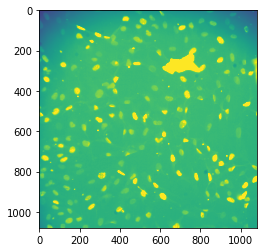

In [24]:
import matplotlib.pyplot as plt
plt.imshow(pcna_img,vmin=0,vmax=10000)

In [25]:
#Normalising the images
def normalise_img(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))

In [26]:
#Gathering the data from each image
#This needs to be a loop and each dataframe needs to be stored in a numpy array

#Step 1: Normalise each channel
#I'd like to eventually have this in a dataframe and normalise them from there
dapi_img = normalise_img(dapi_img)
edu_img = normalise_img(edu_img)
cyclina2_img = normalise_img(cyclina2_img)
pcna_img = normalise_img(pcna_img)

#Step 2: Make mask prediction
#We're making the prediction on the PCNA channel
from cellpose import models
model_dir = "C:\\Users\\rz200\\Documents\\Development\\cell-SCT\\segmentation\\demo_train_test_data\\data_for_masks_training\\models\\demo_model"
model = models.CellposeModel(gpu=True, pretrained_model=model_dir)
test_data = [pcna_img]
predicted_test_masks = model.eval(test_data, channels=[0,0], diameter=model.diam_labels.copy())[0]  # generates the predictions # we could use the fact that it has a channel input to have the normal image not separated by channel and just make it do the prediction on there, although we need it to make a prediction on the averaged out gray image so that wouldn't really work
predicted_mask = predicted_test_masks[0]

#Step 3: Make the crops around each channel and store them in the dataframe

#Step 4: Get the pixel intensity data from each channel and store them in the dataframe

#Step 5: Get the background value for the Cyclin A2 channel and the EdU channel

#Step 6: Get the DAPI DNA content data in a new column from Helfrid's function

#Step 6: Apply the S-phase rule in a new boolean column

#Step 7: Apply the G1 rule in a new boolean column

#Step 8: Apply the G2/M rule in a new boolean column

Prediction has 190 cells
According to the background rule, there are 58 cells in the S phase.
With 190 cells that is 30.53% of cells in S phase.

According to the background rule, there are 114 cells in the G1 phase.
With 190 cells that is 60.0% of cells in G1 phase.

According to the background rule, there are 7 cells in the G2/M phase.
With 190 cells that is 3.68% of cells in G2/M phase.


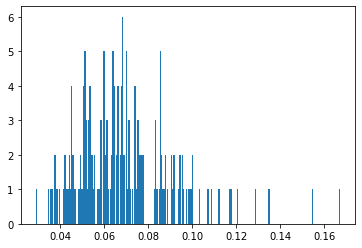

In [182]:
#Step 3: Make the crops around each channel and store them in the dataframe
from segmentation.seg_functions import count_cells, get_cell_crop_coordinates, get_img_crops
print('Prediction has', count_cells(predicted_mask), 'cells')
crop_coordinates = get_cell_crop_coordinates(predicted_mask, margin=3)
dapi_crops = get_img_crops(dapi_img, crop_coordinates)
edu_crops = get_img_crops(edu_img, crop_coordinates)
cyclina2_crops = get_img_crops(cyclina2_img, crop_coordinates)
pcna_crops = get_img_crops(pcna_img, crop_coordinates)

#Step 4: Get the pixel intensity data from each channel and store them in the dataframe
dapi_values = []
edu_values = []
cyclina2_values = []
pcna_values = []
for i in range(len(edu_crops)):
    dapi_values.append(np.average(dapi_crops[i]))
    edu_values.append(np.average(edu_crops[i]))
    cyclina2_values.append(np.average(cyclina2_crops[i]))
    pcna_values.append(np.average(pcna_crops[i]))

dapi_values = np.array(dapi_values)
edu_values = np.array(edu_values)
cyclina2_values = np.array(cyclina2_values)
pcna_values = np.array(pcna_values)

import pandas as pd
cell_data = {'dapi_crops':dapi_crops,
             'edu_crops':edu_crops,
             'cyclina2_crops':cyclina2_crops,
             'pcna_crops':pcna_crops,
             'dapi_values':dapi_values,
             'edu_values':edu_values,
             'cyclina2_values':cyclina2_values,
             'pcna_values':pcna_values}
df = pd.DataFrame(cell_data)

#Step 5: Get the background value for the Cyclin A2 channel and the EdU channel
import numpy.matlib
from statistics import mean

def get_elbow(curve):
    #source:https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve
    nPoints = len(curve)
    allCoord = np.vstack((range(nPoints), curve)).T
    np.array([range(nPoints), curve])
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    return idxOfBestPoint

#This function splits an array into the inputted number and returns the average per split
def get_avg_split_arr(arr,num_splits):
    array_split = np.array_split(arr,num_splits)
    averages = [mean(array) for array in array_split]
    return averages

def get_EdU_threshold(df,column_name):
    edu_nums = np.sort(np.array(df.loc[:,[column_name]]).flatten()) #extract EdU values and put them in one array shape num_of_cells
    #Get the list of EdU values
    #Make a split from 3 to the total number of cells
    #Get the averages at that split
    #Get the elbow in those averages
    #Store that elbow in a list
    #Average out the list of elbow and return that value
    elbows_y = []
    for i in range(140,len(edu_nums)+1):
        avg_split_arr = get_avg_split_arr(edu_nums,i)
        elbow_x = get_elbow(avg_split_arr)
        elbows_y.append(edu_nums[elbow_x])
    return mean(elbows_y)

cyclina2_thresh = get_EdU_threshold(df,'cyclina2_values')
edu_thresh = get_EdU_threshold(df,'edu_values')
#print(cyclina2_thresh,edu_thresh)

#Step 6: Get the DAPI DNA content data in a new column from Helfrid's function
def dna_norm(df,column_name=None):
    """
    normalise histogram of DNA label
    :param df: input dataframe
    :return: input dataframe with additional column: "DNA_content"
    Author/Shared by: Dr Helfrid Hochegger
    """
    if column_name == None: column_name = 'dapi_values'
    y, x, _ = plt.hist(df[column_name], bins=250)
    max = x[np.where(y == y.max())]
    df['DNA_content']=df[column_name]/max[0]
    return df

df = dna_norm(df)

#Step 6: Apply the S-phase rule in a new boolean column
def apply_S_phase_rule(df):
    """
    This function adds a boolean column to indicate if a cell is in the S-phase
    :param df: input dataframe where each row is a cell with a 'EdU_pi' column
    :return: input dataframe with additional column 'S_phase'
    """

    #Step 1: calculate the background color this serves as the threshold for the S-phase
    EdU_threshold = get_EdU_threshold(df,'edu_values')

    #Step 2: Use that threshold in each row to see if a cell is above or below
    #S_phase_cells = df.loc[df['edu_values'] >= EdU_threshold, 'edu_values']

    df['S_Phase'] = np.where( ( df['edu_values'] >= EdU_threshold) , True, False)

    #df["S_Phase"] = "False"
    #df.loc[df['edu_values'].isin(S_phase_cells), "S_Phase"] = "True"

    return df

df = apply_S_phase_rule(df)

#Printing some quantitative data about the cells found in S-phase
num_total_cells = df.S_Phase.value_counts()[0]+df.S_Phase.value_counts()[1]
num_in_s = df.S_Phase.value_counts()[1]
percentage_in_S = round(df.S_Phase.value_counts()[1]*100/num_total_cells,2)
print('According to the background rule, there are {} cells in the S phase.'.format(num_in_s))
print('With {} cells that is {}% of cells in S phase.'.format(num_total_cells,percentage_in_S))

#Step 7: Apply the G1 rule in a new boolean column
#G1: Cyclin A2 negative, EdU negative, DAPI<1.5
def apply_G1_phase_rule(df):
    """
    This function adds a boolean column to indicate if a cell is in the G1-phase
    :param df: input dataframe where each row is a cell with a 'EdU_pi' column
    :return: input dataframe with additional column 'S_phase'
    """

    #Step 1: calculate the background color this serves as the threshold for the S-phase
    cyclina2_thresh = get_EdU_threshold(df,'cyclina2_values')
    edu_thresh = get_EdU_threshold(df,'edu_values')

    #Step 2: Use that threshold in each row to see if a cell is above or below

    df['G1_Phase'] = np.where( ( (df['cyclina2_values'] < cyclina2_thresh) & (df['edu_values'] < edu_thresh)  & (df['DNA_content'] < 1.5) ) , True, False)

    return df

df = apply_G1_phase_rule(df)
#print(df)
#Printing some quantitative data about the cells found in G1 phase
num_total_cells = df.G1_Phase.value_counts()[0]+df.G1_Phase.value_counts()[1]
num_in_g1 = df.G1_Phase.value_counts()[1]
percentage_in_g1 = round(df.G1_Phase.value_counts()[1]*100/num_total_cells,2)
print('\nAccording to the background rule, there are {} cells in the G1 phase.'.format(num_in_g1))
print('With {} cells that is {}% of cells in G1 phase.'.format(num_total_cells,percentage_in_g1))

#Step 8: Apply the G2/M rule in a new boolean column
#G2/M: DAPI (normalised) > 1.5, EdU < background, Cyclin > background
def apply_G2_M_phase_rule(df):
    """
    This function adds a boolean column to indicate if a cell is in the G1-phase
    :param df: input dataframe where each row is a cell with a 'EdU_pi' column
    :return: input dataframe with additional column 'S_phase'
    """

    #Step 1: calculate the background color this serves as the threshold for the S-phase
    cyclina2_thresh = get_EdU_threshold(df,'cyclina2_values')
    edu_thresh = get_EdU_threshold(df,'edu_values')

    #Step 2: Use that threshold in each row to see if a cell is above or below

    df['G2_M_Phase'] = np.where( ( ((df['DNA_content'] > 1.5) & df['cyclina2_values'] > cyclina2_thresh) & (df['edu_values'] < edu_thresh) ) , True, False)

    return df

df = apply_G2_M_phase_rule(df)

#Printing some quantitative data about the cells found in G2 and M phase
num_total_cells = df.G2_M_Phase.value_counts()[0]+df.G2_M_Phase.value_counts()[1]
num_in_g2_m = df.G2_M_Phase.value_counts()[1]
percentage_in_g2_m = round(df.G2_M_Phase.value_counts()[1]*100/num_total_cells,2)
print('\nAccording to the background rule, there are {} cells in the G2/M phase.'.format(num_in_g2_m))
print('With {} cells that is {}% of cells in G2/M phase.'.format(num_total_cells,percentage_in_g2_m))

In [183]:
print(df)

                                            dapi_crops  \
0    [[0.005397470986682161, 0.006498371584532346, ...   
1    [[0.005030504120732099, 0.0033638629378755676,...   
2    [[0.004969342976407089, 0.004158957814100702, ...   
3    [[0.00467882754086329, 0.003899022950719408, 0...   
4    [[0.004556505252213269, 0.00574914756655097, 0...   
..                                                 ...   
185  [[0.005061084692894604, 0.004281280102750722, ...   
186  [[0.004877601259919573, 0.005015213834650846, ...   
187  [[0.004831730401675815, 0.005229277839788382, ...   
188  [[0.003746120089906882, 0.004097796669775691, ...   
189  [[0.005229277839788382, 0.005351600128438403, ...   

                                             edu_crops  \
0    [[0.00574555936428794, 0.0054728887503895296, ...   
1    [[0.005726082891866625, 0.0058234652539732, 0....   
2    [[0.0051807416640698035, 0.005570271112496104,...   
3    [[0.006135088812714241, 0.005726082891866625, ...   
4    [[0.0064

In [222]:
maxes = []
for j in range(len(df['dapi_crops'])):
    for i in range(len(df['dapi_crops'][j])):
        maxes.append(max(df['dapi_crops'][j][i]))
print(max(maxes))

1.0


S phase cells in 4 channels


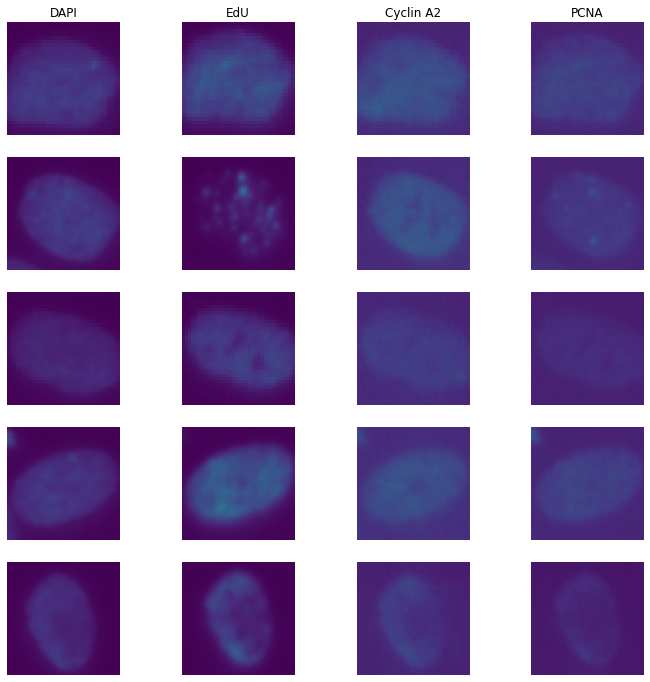

In [253]:
#Let's plot some cells of each phase here, I want the 4 channels each time

#Plotting S_phase cells
is_S = df['S_Phase']==True
count = 0
i = 0
num_cells = 5
plt.figure(figsize=(12,12))
while count < num_cells*4:
    if is_S[i]:

        plt.subplot(5,4,count+1)
        if count == 0: plt.title('DAPI')
        plt.imshow(df['dapi_crops'][i],vmin=0,vmax=1);plt.axis('off')

        plt.subplot(5,4,count+2)
        if count == 0: plt.title('EdU')
        plt.imshow(df['edu_crops'][i],vmin=0,vmax=1);plt.axis('off')

        plt.subplot(5,4,count+3)
        if count == 0: plt.title('Cyclin A2')
        plt.imshow(df['cyclina2_crops'][i],vmin=0,vmax=1);plt.axis('off')

        plt.subplot(5,4,count+4)
        if count == 0: plt.title('PCNA')
        plt.imshow(df['pcna_crops'][i],vmin=0,vmax=1);plt.axis('off')

        count += 4
        i+=1
    else:i+=1
print('S phase cells in 4 channels')
plt.show()

G1 phase cells in 4 channels


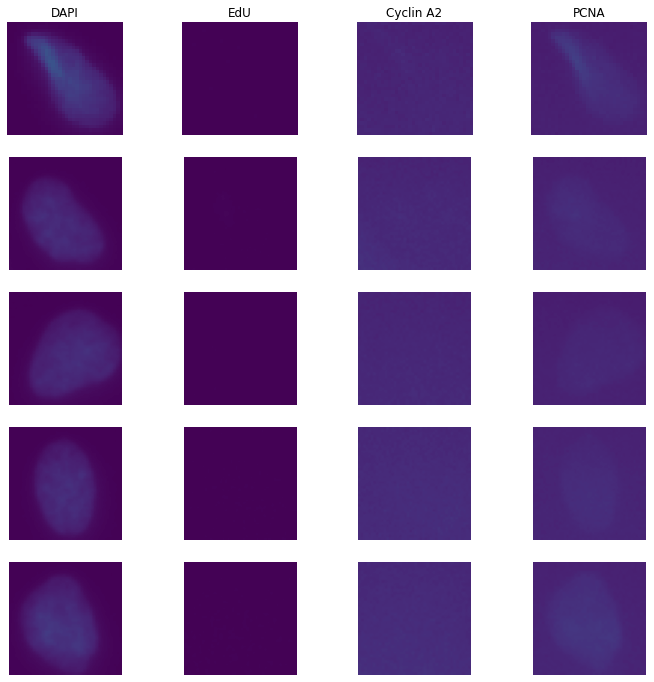

In [254]:
#Plotting G1_phase cells
is_G1 = df['G1_Phase']==True
count = 0
i = 0
num_cells = 5
plt.figure(figsize=(12,12))
while count < num_cells*4:
    if is_G1[i]:

        plt.subplot(5,4,count+1)
        if count == 0: plt.title('DAPI')
        plt.imshow(df['dapi_crops'][i],vmin=0,vmax=1);plt.axis('off')

        plt.subplot(5,4,count+2)
        if count == 0: plt.title('EdU')
        plt.imshow(df['edu_crops'][i],vmin=0,vmax=1);plt.axis('off')

        plt.subplot(5,4,count+3)
        if count == 0: plt.title('Cyclin A2')
        plt.imshow(df['cyclina2_crops'][i],vmin=0,vmax=1);plt.axis('off')

        plt.subplot(5,4,count+4)
        if count == 0: plt.title('PCNA')
        plt.imshow(df['pcna_crops'][i],vmin=0,vmax=1);plt.axis('off')

        count += 4
        i+=1
    else:i+=1
print('G1 phase cells in 4 channels')
plt.show()

G2/M phase cells in 4 channels


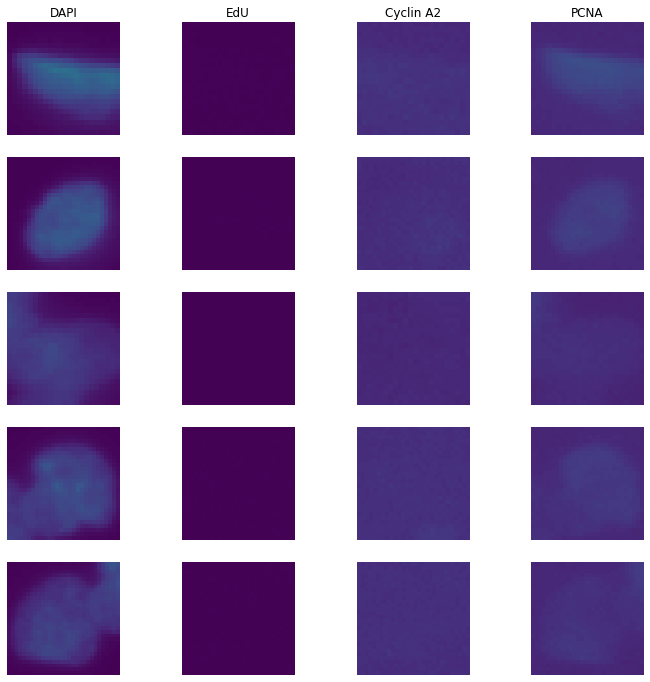

In [255]:
#Plotting G2_M_phase cells
is_G2_M = df['G2_M_Phase']==True
count = 0
i = 0
num_cells = 5
plt.figure(figsize=(12,12))
while count < num_cells*4:
    if is_G2_M[i]:

        plt.subplot(5,4,count+1)
        if count == 0: plt.title('DAPI')
        plt.imshow(df['dapi_crops'][i],vmin=0,vmax=1);plt.axis('off')

        plt.subplot(5,4,count+2)
        if count == 0: plt.title('EdU')
        plt.imshow(df['edu_crops'][i],vmin=0,vmax=1);plt.axis('off')

        plt.subplot(5,4,count+3)
        if count == 0: plt.title('Cyclin A2')
        plt.imshow(df['cyclina2_crops'][i],vmin=0,vmax=1);plt.axis('off')

        plt.subplot(5,4,count+4)
        if count == 0: plt.title('PCNA')
        plt.imshow(df['pcna_crops'][i],vmin=0,vmax=1);plt.axis('off')

        count += 4
        i+=1
    else:i+=1
print('G2/M phase cells in 4 channels')
plt.show()

In [ ]:
#Plotting a 4D axis from each channel's value

In [332]:
#Function to take a dataframe and extract the PCNA images with their label in one hot encoding

def get_training_data(df):

    pcna_images = df['pcna_crops'].values

    cycle_phase_encodings = []
    for i in range(len(df['S_Phase'])):
        encoding_arr = []
        if df['G1_Phase'][i]: encoding_arr.append(1)
        else: encoding_arr.append(0)

        if df['S_Phase'][i]: encoding_arr.append(1)
        else: encoding_arr.append(0)

        if df['G2_M_Phase'][i]: encoding_arr.append(1)
        else: encoding_arr.append(0)

        cycle_phase_encodings.append(encoding_arr)

    training_data = []
    for j in range(len(pcna_images)):
        training_data.append((pcna_images[j],cycle_phase_encodings[j]))

    training_data = np.array(training_data,dtype=object)

    return training_data

In [287]:
training_data = get_training_data(df)

In [292]:
print(training_data[:,0])

[array([[0.08049884, 0.08262065, 0.08573841, ..., 0.07660164, 0.0777708 ,
         0.07755429],
        [0.08004417, 0.08404962, 0.08298872, ..., 0.07995756, 0.08106177,
         0.0748479 ],
        [0.07636348, 0.07692641, 0.07939463, ..., 0.0777275 , 0.07493451,
         0.08099682],
        ...,
        [0.08796848, 0.09048001, 0.0943339 , ..., 0.09697534, 0.09342456,
         0.09076147],
        [0.08550025, 0.08926754, 0.08799013, ..., 0.0951783 , 0.09407409,
         0.09154091],
        [0.08619308, 0.09496179, 0.09082642, ..., 0.09149761, 0.09045835,
         0.09658562]])
 array([[0.08744885, 0.09164917, 0.08586832, ..., 0.0825557 , 0.08773031,
         0.08515383],
        [0.08768701, 0.08573841, 0.08617143, ..., 0.08244744, 0.08829324,
         0.08359495],
        [0.08593327, 0.08814168, 0.08822829, ..., 0.08861801, 0.09286163,
         0.08537034],
        ...,
        [0.10775759, 0.10357893, 0.101154  , ..., 0.101154  , 0.10240977,
         0.09652067],
        [0.09

In [377]:
from torch.nn import Dropout2d
import cv2
#Let's train a small CNN on the training data we have to see how it does
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F

train = training_data
#test = pd.read_csv('test_ScVgIM0/test.csv')

#sample_submission = pd.read_csv('sample_submission_I5njJSF.csv')

train_img = training_data[:,0]
train_img_padded = []

for i in range(len(train_img)):
    train_img_padded.append(cv2.copyMakeBorder(train_img[i], 60-train_img[i].shape[0], 0, 60-train_img[i].shape[1], 0, cv2.BORDER_CONSTANT))

train_y = []
print('train data shape',training_data[:,1].shape)
for encoding in training_data[:,1]:
    if encoding == [1,0,0]:
        train_y.append(0)
    elif encoding == [0,1,0]:
        train_y.append(1)
    elif encoding == [0,0,1]:
        train_y.append(2)

train_x = []
for i in range(len(train_img_padded)):
    if training_data[:,1][i] != [0,0,0]:
        train_x.append(train_img_padded[i])

train_y = np.array(train_y)
print('train_y shape',train_y.shape)
train_x = np.array(train_x)
print('train_x shape',train_x.shape)

def scale(im, nR, nC):
    nR0 = len(im)     # source number of rows
    nC0 = len(im[0])  # source number of columns
    return [[ im[int(nR0 * r / nR)][int(nC0 * c / nC)]
              for c in range(nC)] for r in range(nR)]

train_x_resized = []
for image in train_x:
    train_x_resized.append(scale(image,28,28))
train_x_resized = np.array(train_x_resized)

train_x, val_x, train_y, val_y = train_test_split(train_x_resized, train_y, test_size = 0.1)
train_x = np.array(train_x)
val_x = np.array(val_x)
val_y = np.array(val_y)
#(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)
print((train_x.shape, train_y.shape), (val_x.shape, val_y.shape))


# converting training images into torch format
train_x = train_x.reshape(161, 1, 28, 28)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(float);
train_y = torch.from_numpy(train_y)

# converting validation images into torch format
val_x = val_x.reshape(18, 1, 28, 28)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(float);
val_y = torch.from_numpy(val_y)

class Net(Module):
    def __init__(self):
        super(Net, self).__init__()

        # First 2D convolutional layer, taking in 1 input channel (image),
        # outputting 32 convolutional features, with a square kernel size of 3
        self.conv1 = Conv2d(1, 32, 3, 1)
        # Second 2D convolutional layer, taking in the 32 input layers,
        # outputting 64 convolutional features, with a square kernel size of 3
        self.conv2 = Conv2d(32, 64, 3, 1)

        # Designed to ensure that adjacent pixels are either all 0s or all active
        # with an input probability
        self.dropout1 = Dropout2d(0.25)
        self.dropout2 = Dropout2d(0.5)

        # First fully connected layer
        self.fc1 = Linear(9216, 128)
        # Second fully connected layer that outputs our 10 labels
        self.fc2 = Linear(128, 1)

    # Defining the forward pass
    def forward(self, x):
        # Pass data through conv1
        x = self.conv1(x)
        # Use the rectified-linear activation function over x
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        # Run max pooling over x
        x = F.max_pool2d(x, 2)
        # Pass data through dropout1
        x = self.dropout1(x)
        # Flatten x with start_dim=1
        x = torch.flatten(x, 1)
        # Pass data through fc1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        # Apply softmax to x
        output = F.log_softmax(x, dim=1)
        return output

# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

train data shape (190,)
train_y shape (179,)
train_x shape (179, 60, 60)
((161, 28, 28), (161,)) ((18, 28, 28), (18,))
Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [378]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    print(x_train.shape)
    print(y_train.shape)

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()

    # prediction for training and validation set
    x_train = x_train.float()
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    y_train = y_train.float()
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

torch.Size([161, 1, 28, 28])
torch.Size([161])
Unexpected exception formatting exception. Falling back to standard exception


C:\Users\rz200\.conda\envs\celldev\lib\site-packages\torch\nn\functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Traceback (most recent call last):
  File "C:\Users\rz200\.conda\envs\celldev\lib\site-packages\IPython\core\interactiveshell.py", line 3397, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\rz200\AppData\Local\Temp\ipykernel_20352\3014173751.py", line 49, in <cell line: 48>
    train(epoch)
  File "C:\Users\rz200\AppData\Local\Temp\ipykernel_20352\3014173751.py", line 24, in train
    output_val = model(x_val)
  File "C:\Users\rz200\.conda\envs\celldev\lib\site-packages\torc

In [374]:
random_data = torch.rand((6, 1, 28, 28))
print(random_data.shape)

my_nn = Net()
result = my_nn(random_data)
print (result)

torch.Size([6, 1, 28, 28])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<LogSoftmaxBackward0>)


In [182]:
#Put all the data together for a quantitative investigation

#Step 1: Stack all the dataframes together

#Step 2: Plot that cell cycle phase channel data in a 4D graph where each axis is data from a channel

#Step 3: Plot some cells from each classification cropped in the Alexa555 channel

#Step 4: A Venn diagram of the cell phases with their True or False, we'll see some applying to the same rules

Number of cells only in S phase: 58
Number of cells only in G1 phase: 114
Number of cells only in G2/M phase: 7
Number of cells only in S and G1 phase: 0
Number of cells only in S and G2/M phase: 0
Number of cells only in G1 and G2/M phase: 0
Number of cells labelled (G1, S and G2/M): 0
Number of cells not labelled: 11


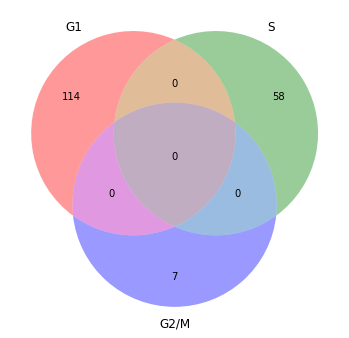

In [181]:
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted

g1_values = np.asarray(df['G1_Phase'],dtype=bool)
s_values = np.asarray(df['S_Phase'],dtype=bool)
g2_m_values = np.asarray(df['G2_M_Phase'],dtype=bool)

only_s = sum(~g1_values & s_values & ~g2_m_values)
only_g1 = sum(g1_values & ~s_values & ~g2_m_values)
only_g2_m = sum(~g1_values & ~s_values & g2_m_values)
g1_and_s = sum(g1_values & s_values & ~g2_m_values)
g1_and_g2_m = sum(g1_values & ~s_values & g2_m_values)
s_and_g2_m = sum(~g1_values & s_values & g2_m_values)
g1_and_s_and_g2_m = sum(g1_values & s_values & g2_m_values)
no_label = sum(~g1_values & ~s_values & ~g2_m_values)

#print(only_g1,only_s,only_g2_m,g1_and_s,g1_and_g2_m,s_and_g2_m,g1_and_s_and_g2_m)
print('Number of cells only in S phase:',only_s)
print('Number of cells only in G1 phase:',only_g1)
print('Number of cells only in G2/M phase:',only_g2_m)
print('Number of cells only in S and G1 phase:',g1_and_s)
print('Number of cells only in S and G2/M phase:',s_and_g2_m)
print('Number of cells only in G1 and G2/M phase:',g1_and_g2_m)
print('Number of cells labelled (G1, S and G2/M):',g1_and_s_and_g2_m)
print('Number of cells not labelled:',no_label)

#venn3(subsets = (only_g1, only_s, g1_and_s, only_g2_m, g1_and_g2_m, s_and_g2_m, g1_and_s_and_g2_m), set_labels = ('G1', 'S', 'G2/M'))
plt.figure(figsize=(6,6))
v = venn3_unweighted(subsets = (only_g1, only_s, g1_and_s, only_g2_m, g1_and_g2_m, s_and_g2_m, g1_and_s_and_g2_m),
                     set_labels = ('G1', 'S', 'G2/M'))
#c = venn3_circles(subsets = (only_g1, only_s, g1_and_s, only_g2_m, g1_and_g2_m, s_and_g2_m, g1_and_s_and_g2_m),linestyle='dashed')

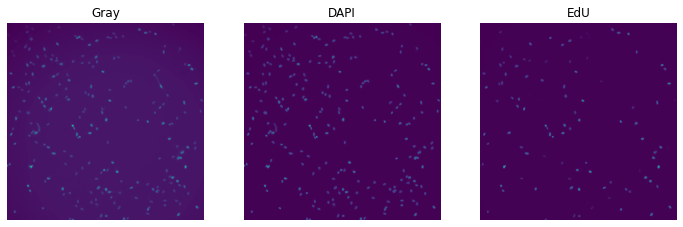

In [148]:
#TODELETE: Here we were importing images from a directory but now we'll do with Omero
#Here we get the images from a directory in the project, normalise and display them

import numpy as np
import matplotlib.pyplot as plt

#Loading the images
gray_img = np.load('/Users/rehanzuberi/Documents/Development/cell-SCT/classification/images/gray_img.npy')
dapi_img = np.load('/Users/rehanzuberi/Documents/Development/cell-SCT/classification/images/dapi_img.npy')
edu_img = np.load('/Users/rehanzuberi/Documents/Development/cell-SCT/classification/images/cy5_img.npy')

#Normalising the images
def normalise_img(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))

gray_img = normalise_img(gray_img)
dapi_img = normalise_img(dapi_img)
edu_img = normalise_img(edu_img)

#Displaying the images
plt.figure(figsize=(12,12))
plt.subplot(1,3,1);plt.imshow(gray_img);plt.axis('off');plt.title('Gray')
plt.subplot(1,3,2);plt.imshow(dapi_img);plt.axis('off');plt.title('DAPI')
plt.subplot(1,3,3);plt.imshow(edu_img);plt.axis('off');plt.title('EdU');plt.show()

In [149]:
#Make a segmentation prediction, right now with the Gray image as that's all we have, later with the Alexa555 (PCNA) image

from cellpose import models
model_dir = "/Users/rehanzuberi/Documents/Development/cell-SCT/segmentation/demo_train_test_data/data_for_masks_training/models/demo_model"
model = models.CellposeModel(gpu=True, pretrained_model=model_dir)
test_data = [gray_img]
predicted_test_masks = model.eval(test_data, channels=[0,0], diameter=model.diam_labels.copy())[0]  # generates the predictions # we could use the fact that it has a channel input to have the normal image not separated by channel and just make it do the prediction on there, although we need it to make a prediction on the averaged out gray image so that wouldn't really work
predicted_mask = predicted_test_masks[0]

In [150]:
#Now we get the crops from each channel and store them in a numpy array
import segmentation.seg_functions
from importlib import reload
from segmentation.seg_functions import count_cells, get_cell_crop_coordinates, get_img_crops
segmentation.seg_functions = reload(segmentation.seg_functions)

print('Prediction has', count_cells(predicted_mask), 'cells')
crop_coordinates = get_cell_crop_coordinates(predicted_mask, margin=3)
gray_crops = get_img_crops(gray_img, crop_coordinates)
dapi_crops = get_img_crops(dapi_img, crop_coordinates)
edu_crops = get_img_crops(edu_img, crop_coordinates)

#We could have one numpy array called 'cells' that holds the images and later on the values

Prediction has 146 cells


In [151]:
mines = []
for i in range(len(gray_crops[0])):
    mines.append(min(gray_crops[0][i]))
print(min(mines))

0.0277490490297474


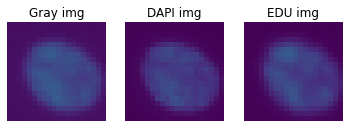

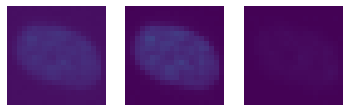

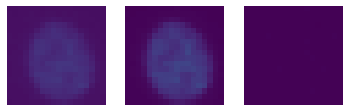

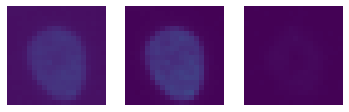

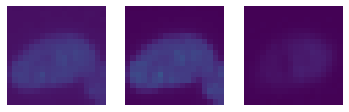

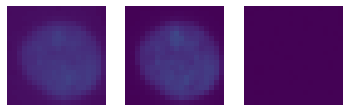

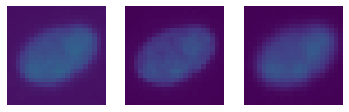

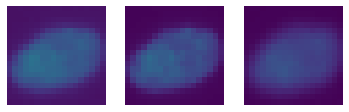

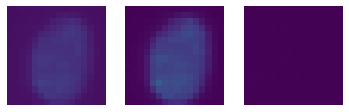

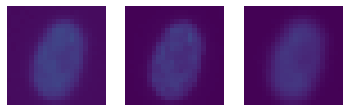

In [152]:
for i in range(10):
    plt.subplot(1,3,1)
    if i == 0: plt.title('Gray img')
    plt.axis('off')
    plt.imshow(gray_crops[i], vmin=0, vmax=1)

    plt.subplot(1,3,2)
    if i == 0: plt.title('DAPI img')
    plt.axis('off')
    plt.imshow(dapi_crops[i], vmin=0, vmax=1)

    plt.subplot(1,3,3)
    if i == 0: plt.title('EDU img')
    plt.imshow(edu_crops[i], vmin=0, vmax=1)
    plt.axis('off')
    plt.show()

In [153]:
#This is what we used to measure the pixel intentisty values of the cells on different channels
#We would put them into one array
#Now I think I would prefer putting them into each their own numpy array
#This also depends on what Helfrid's normalisation funcitions ofers
dapi_values = []
edu_values = []
for i in range(len(edu_crops)):
    dapi_values.append(np.average(dapi_crops[i]))
    edu_values.append(np.average(edu_crops[i]))

dapi_values = np.array(dapi_values)
edu_values = np.array(edu_values)

In [154]:
print(dapi_values)

[0.08189056 0.06061702 0.07178029 0.06219528 0.08757167 0.0813219
 0.07720045 0.11899516 0.0910181  0.05323035 0.07213572 0.05294544
 0.04957388 0.05580228 0.0703837  0.11281957 0.06128804 0.06254169
 0.08312426 0.06264807 0.06410132 0.08668238 0.10614746 0.13072385
 0.05873736 0.09924094 0.07452244 0.14827078 0.06161165 0.06965249
 0.07038366 0.04812316 0.07623968 0.08474177 0.09208622 0.08798822
 0.12561442 0.0692778  0.10407916 0.07032933 0.09084809 0.12494403
 0.06520222 0.07878614 0.08220033 0.0658569  0.07558843 0.11137212
 0.08114326 0.07608225 0.07860151 0.07778704 0.06582289 0.07290062
 0.08823902 0.20608641 0.06261691 0.11870651 0.05695263 0.08710398
 0.09521057 0.09362389 0.07557514 0.06830532 0.06456485 0.07700331
 0.05690713 0.0937765  0.07176176 0.07874459 0.11717204 0.08642276
 0.07763172 0.10980914 0.16022615 0.11570083 0.08893362 0.07429999
 0.0998013  0.06464597 0.06885665 0.14068977 0.16486924 0.06176055
 0.06363109 0.05801578 0.12779022 0.07792027 0.08694195 0.07485

In [155]:
def dna_norm(df):
    """
    normalise histogram of DNA label
    :param df: input dataframe
    :return: input dataframe with additional column: "DNA_content"
    Author/Shared by: Dr Helfrid Hochegger
    """
    y, x, _ = plt.hist(df['integrated_int_DAPI'], bins=250)
    max = x[np.where(y == y.max())]
    df['DNA_content']=df['integrated_int_DAPI']/max[0]
    return df

In [157]:
import pandas as pd

#pi: pixel intensity

cell_data = {'Gray cell img':gray_crops, 'integrated_int_DAPI':dapi_values, 'EdU_pi':edu_values}
df = pd.DataFrame(cell_data)

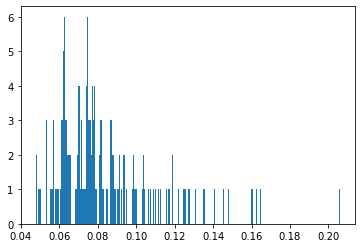

In [158]:
normalised = dna_norm(df)

In [159]:
print(normalised)

                                         Gray cell img  integrated_int_DAPI  \
0    [[0.0353042228338037, 0.031815871123810194, 0....             0.081891   
1    [[0.037539222044980454, 0.03568110505372763, 0...             0.060617   
2    [[0.037635633775658664, 0.038073868915105086, ...             0.071780   
3    [[0.04317492593826144, 0.04319245534383929, 0....             0.062195   
4    [[0.03940610373902221, 0.03749539853103581, 0....             0.087572   
..                                                 ...                  ...   
141  [[0.05808368538222869, 0.058153803004540115, 0...             0.047726   
142  [[0.059652567181446875, 0.06052903746033972, 0...             0.074366   
143  [[0.052842393114449486, 0.052526863814048065, ...             0.097904   
144  [[0.05951233193682402, 0.056926744614090134, 0...             0.050182   
145  [[0.056357038932809786, 0.05409574561326625, 0...             0.103522   

       EdU_pi  DNA_content  
0    0.091203     1.31

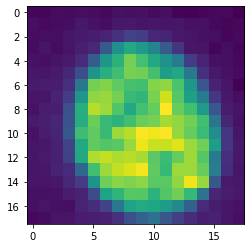

In [160]:
#We need to get the colour of the background for the EdU since not being the same colour of the background gives info
plt.imshow(df.sort_values(by=['EdU_pi'])['Gray cell img'][2])

In [161]:
from statistics import mean
import numpy.matlib

def get_elbow(curve):
    #source:https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve
    nPoints = len(curve)
    allCoord = np.vstack((range(nPoints), curve)).T
    np.array([range(nPoints), curve])
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    return idxOfBestPoint

#This function splits an array into the inputted number and returns the average per split
def get_avg_split_arr(arr,num_splits):
    array_split = np.array_split(arr,num_splits)
    averages = [mean(array) for array in array_split]
    return averages

def get_EdU_threshold(df):
    edu_nums = np.sort(np.array(df.loc[:,['EdU_pi']]).flatten()) #extract EdU values and put them in one array shape num_of_cells

    #Get the list of EdU values
    #Make a split from 3 to the total number of cells
    #Get the averages at that split
    #Get the elbow in those averages
    #Store that elbow in a list
    #Average out the list of elbow and return that value

    elbows_y = []
    for i in range(140,len(edu_nums)+1):
        avg_split_arr = get_avg_split_arr(edu_nums,i)
        elbow_x = get_elbow(avg_split_arr)
        elbows_y.append(edu_nums[elbow_x])

    #print(elbows_y)

    return mean(elbows_y)

EdU intensity threshold: 0.010146958946061274


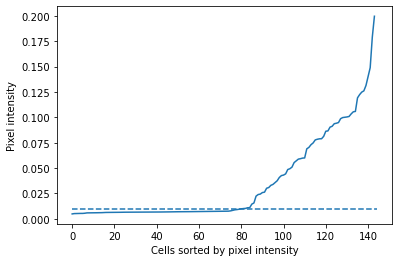

In [162]:
#I'm trying to find the background color in the EdU channel
#Let's try putting the values in buckets
#From this bucket method I would conclude that the background is at 500
from statistics import mean

num_buckets = 144
edu_nums = np.array(df.loc[:,['EdU_pi']]).flatten()
edu_nums = np.sort(edu_nums)
edu_nums = np.array_split(edu_nums,num_buckets)
averages = []
for array in edu_nums: averages.append(mean(array))
import matplotlib.pyplot as plt
fig = plt.figure()
bars = [i+1 for i in range(num_buckets)]
y_pos = np.arange(len(bars))
#plt.bar(y_pos, averages)
plt.plot(averages)
plt.xlabel('Cells sorted by pixel intensity')
plt.ylabel('Pixel intensity')
#plt.yticks([i for i in range(0,5000,250)])
#plt.xticks(y_pos, bars)
#plt.grid('on')


#Need to fid the elbow
#from kneed import KneeLocator
#kn = KneeLocator(bars, averages, curve='convex', direction='increasing')
#print('Elbow y value: {}',averages[kn.knee])

#plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed') #plotting the line
plt.hlines(get_EdU_threshold(df), xmin=0, xmax=max(bars), linestyles='dashed')
print('EdU intensity threshold:',get_EdU_threshold(df))

plt.show()

In [163]:
#To find intersection
#Create for the line a list of tuples with all of its X and Y coordinates
#Do the same for our list of cell values
#Get the point that they cross at

In [164]:
print(get_EdU_threshold(df))

0.010146958946061274


0.004687097051491447


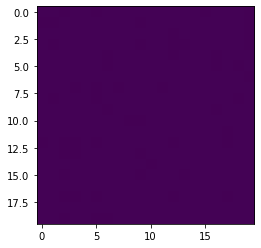

0.005085962348491359


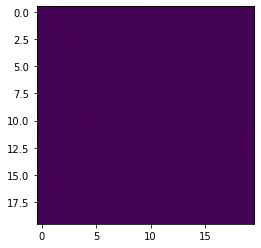

0.005206116840165572


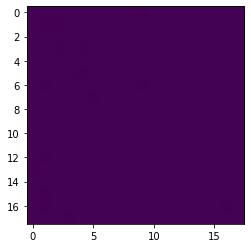

0.005209839302506715


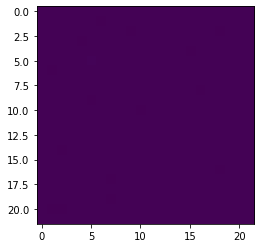

In [165]:
#Showing the EdU channel images by lowest EdU to highest
indices = np.array(df.sort_values(by=['EdU_pi']).index) #sort cells by smallest value of EdU
for i in indices[:4]:
    print(df['EdU_pi'][i])
    plt.imshow(edu_crops[i],vmin=0,vmax=1);plt.show()

In [166]:
#Applying the S phase rule

#In the cell dataframe, we can now add the S phase label
#Apply a rule where every row where EdU is lower than 500 is the S-phase
background = 500 #pixel intensity
s_phase_cells = df.loc[df["EdU_pi"] >= 500, "EdU_pi"]
df["S_Phase"] = "False"
df.loc[df["EdU_pi"].isin(s_phase_cells), "S_Phase"] = "True"

In [167]:
print(df.S_Phase.value_counts()[0])
print(df.S_Phase)

146
0      False
1      False
2      False
3      False
4      False
       ...  
141    False
142    False
143    False
144    False
145    False
Name: S_Phase, Length: 146, dtype: object


In [172]:
#Setting up the cell dataframe
cell_data = {'Gray cell img': gray_crops, 'integrated_int_DAPI': dapi_values, 'EdU_pi': edu_values}
df = pd.DataFrame(cell_data)
print(df)

                                         Gray cell img  integrated_int_DAPI  \
0    [[0.0353042228338037, 0.031815871123810194, 0....             0.081891   
1    [[0.037539222044980454, 0.03568110505372763, 0...             0.060617   
2    [[0.037635633775658664, 0.038073868915105086, ...             0.071780   
3    [[0.04317492593826144, 0.04319245534383929, 0....             0.062195   
4    [[0.03940610373902221, 0.03749539853103581, 0....             0.087572   
..                                                 ...                  ...   
141  [[0.05808368538222869, 0.058153803004540115, 0...             0.047726   
142  [[0.059652567181446875, 0.06052903746033972, 0...             0.074366   
143  [[0.052842393114449486, 0.052526863814048065, ...             0.097904   
144  [[0.05951233193682402, 0.056926744614090134, 0...             0.050182   
145  [[0.056357038932809786, 0.05409574561326625, 0...             0.103522   

       EdU_pi  
0    0.091203  
1    0.014536  
2  

In [175]:
def apply_S_phase_rule(df):
    """
    This function adds a boolean column to indicate if a cell is in the S-phase
    :param df: input dataframe where each row is a cell with a 'EdU_pi' column
    :return: input dataframe with additional column 'S_phase'
    """

    #Step 1: calculate the background color this serves as the threshold for the S-phase
    EdU_threshold = get_EdU_threshold(df)

    #Step 2: Use that threshold in each row to see if a cell is above or below
    S_phase_cells = df.loc[df["EdU_pi"] >= EdU_threshold, "EdU_pi"]
    df["S_Phase"] = "False"
    df.loc[df["EdU_pi"].isin(S_phase_cells), "S_Phase"] = "True"

    return df

In [178]:
#Applying the S-phase rule
df = apply_S_phase_rule(df)
print(df,'\n')

#Printing some quantitative data about the cells found in S-phase
num_total_cells = df.S_Phase.value_counts()[0]+df.S_Phase.value_counts()[1]
num_in_s = df.S_Phase.value_counts()[1]
percentage_in_S = round(df.S_Phase.value_counts()[1]*100/num_total_cells,2)
print('According to the background rule, there are {} cells in the S phase.'.format(num_in_s))
print('With {} cells that is {}% of cells in S phase.'.format(num_total_cells,percentage_in_S))

                                         Gray cell img  integrated_int_DAPI  \
0    [[0.0353042228338037, 0.031815871123810194, 0....             0.081891   
1    [[0.037539222044980454, 0.03568110505372763, 0...             0.060617   
2    [[0.037635633775658664, 0.038073868915105086, ...             0.071780   
3    [[0.04317492593826144, 0.04319245534383929, 0....             0.062195   
4    [[0.03940610373902221, 0.03749539853103581, 0....             0.087572   
..                                                 ...                  ...   
141  [[0.05808368538222869, 0.058153803004540115, 0...             0.047726   
142  [[0.059652567181446875, 0.06052903746033972, 0...             0.074366   
143  [[0.052842393114449486, 0.052526863814048065, ...             0.097904   
144  [[0.05951233193682402, 0.056926744614090134, 0...             0.050182   
145  [[0.056357038932809786, 0.05409574561326625, 0...             0.103522   

       EdU_pi S_Phase  
0    0.091203    True  
1  

In [ ]:

normalised = dna_norm(df)

In [ ]:
#Rules given by Dr Hochegger for the cell cycle classification

#G1: Cyclin A2 negative, EdU negative, DAPI<1.5
#S: EdU > background
#G2/M: DAPI (normalised) > 1.5, EdU < background, Cyclin > background

#Terminology
#DAPI is DAPI
#Cy5 is the EdU
#Alexa555 is PCNA
#Alexa488 is Cyclin A2